# Images & Convolutional Neural Networks

Train neural networks to solve image classification tasks. In this chapter, you will learn how to handle image data in PyTorch and get to grips with convolutional neural networks (CNNs). You will practice training and evaluating an image classifier while learning about how to improve the model performance with data augmentation.


In [18]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.optim as optim
from torchmetrics import Precision, Recall

## Handling images with PyTorch


### Image dataset

Let's start with building a Torch Dataset of images. You'll use it to explore the data and, later, to feed it into a model.
The training data for the cloud classification task is stored in the following directory structure:

```
datasets/clouds/clouds_train
  - cirriform clouds
    - 539cd1c356e9c14749988a12fdf6c515.jpg
    - ...
  - clear sky
  - cumulonimbus clouds
  - cumulus clouds
  - high cumuliform clouds
  - stratiform clouds
  - stratocumulus clouds
```

There are seven folders inside clouds_train, each representing one cloud type (or a clear sky). Inside each of these folders sit corresponding image files.


Instructions:

- Compose two transformations, the first, to parse the image to a tensor, and one to resize the image to `128` by `128`, assigning them to `train_transforms`.
- Use `ImageFolder` to define `dataset_train`, passing it the directory path to the data ("clouds_train") and the transforms defined earlier.


In [10]:
# Compose transformations
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((128, 128)),
    ]
)

# Create Dataset using ImageFolder
dataset_train = ImageFolder(
    root="datasets/clouds/clouds_train",
    transform=train_transforms,
)

### Data augmentation in PyTorch

Let's include data augmentation in your Dataset and inspect some images visually to make sure the desired transformations are applied.

First, you'll add the augmenting transformations to `train_transforms`. Let's use a random horizontal flip and a rotation by a random angle between 0 and 45 degrees. The code that follows to create the Dataset and the DataLoader is exactly the same as before. Finally, you'll reshape the image and display it to see if the new augmenting transformations are visible.


Instructions:

- Add two more transformations to `train_transforms` to perform a random horizontal flip and then a rotation by a random angle between 0 and 45 degrees.
- Reshape the `image` tensor from the DataLoader to make it suitable for display.
- Display the image.


c:\Users\jcamp\.conda\envs\deep-learning-track-gpu\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


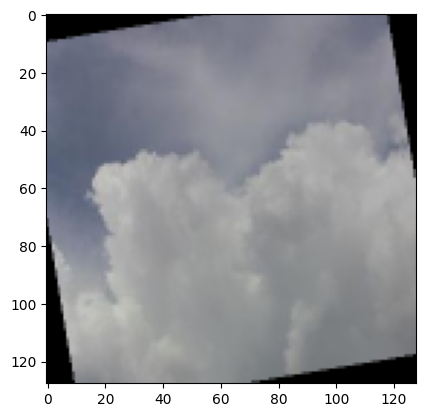

In [11]:
train_transforms = transforms.Compose(
    [
        # Add horizontal flip and rotation
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((0, 45)),
        transforms.ToTensor(),
        transforms.Resize((128, 128)),
    ]
)

dataset_train = ImageFolder(
    "datasets/clouds/clouds_train",
    transform=train_transforms,
)


dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=1)

image, label = next(iter(dataloader_train))

# Reshape the image tensor
image = image.squeeze().permute(1, 2, 0)

# Display the image
plt.imshow(image)
plt.show()

## Convolutional Neural Networks

### Building convolutional networks

You are on a team building a weather forecasting system. As part of the system, cameras will be installed at various locations to take pictures of the sky. Your task is to build a model to classify different cloud types in these pictures, which will help spot approaching weather fronts.

You decide to build a convolutional image classifier. The model will consist of two parts:

A feature extractor that learns a vector of features from the input image,
A classifier that predicts the image's class based on the learned features.

Instructions:

- Define the `feature_extractor` part of the model by adding another convolutional layer with `64` output feature maps, the ELU activation, and a max pooling layer with a window of size two; at the end, flatten the output.
- Define the `classifier` part of the model as a single linear layer with a number of inputs that reflects an input image of 64x64 and the feature extractor defined; the classifier should have `num_classes` outputs
- In the `forward()` method, pass the input image `x` first through the feature extractor and then through the classifier.


In [12]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        # Define classifier
        self.classifier = nn.Linear(64 * 16 * 16, num_classes)

    def forward(self, x):
        # Pass input through feature extractor and classifier
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

## Training image classifiers


### Dataset with augmentations

You have already built the image dataset from cloud pictures and the convolutional model to classify different cloud types. Before you train it, let's adapt the dataset by adding the augmentations that could improve the model's cloud classification performance.

The code to set up the Dataset and DataLoader is already prepared for you and should look familiar. Your task is to define the composition of transforms that will be applied to the input images as they are loaded.

Note that before you were resizing images to 128 by 128 to display them nicely, but now you will use smaller ones to speed up training. As you will see later, 64 by 64 will be large enough for the model to learn.

Instructions:

- Define `train_transforms` by composing together five transformations: a random horizontal flip, random rotation (by angle from 0 to 45 degrees), random automatic contrast adjustment, parsing to tensor, and resizing to 64 by 64 pixels.


In [13]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((0,45)),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((64,64)),
])

dataset_train = ImageFolder(
  "datasets/clouds/clouds_train",
  transform=train_transforms,
)
dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=16
)

### Image classifier training loop

It's time to train the image classifier! You will use the Net you defined earlier and train it to distinguish between seven cloud types.

To define the loss and optimizer, you will need to use functions from `torch.nn` and `torch.optim`, imported for you as `nn` and `optim`, respectively. You don't need to change anything in the training loop itself: it's exactly like the ones you wrote before, with some additional logic to print the loss during training.

Instruction: 

- Define the model using your `Net` class with `num_classes` set to 7 and assign it to net.
- Define the loss function as cross-entropy loss and assign it to `criterion`.
- Define the optimizer as Adam, passing it the model's parameters and the learning rate of `0.001`, and assign it to `optimizer`.
- Start the training for-loop by iterating over training `images` and `labels`.

In [42]:
# Define the model
net = Net(num_classes=7)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(params=net.parameters(), lr=0.0001)

for epoch in range(100):
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 1.8273
Epoch 2, Loss: 1.7422
Epoch 3, Loss: 1.6581
Epoch 4, Loss: 1.5748
Epoch 5, Loss: 1.4847
Epoch 6, Loss: 1.4132
Epoch 7, Loss: 1.3851
Epoch 8, Loss: 1.3267
Epoch 9, Loss: 1.2779
Epoch 10, Loss: 1.2605
Epoch 11, Loss: 1.1957
Epoch 12, Loss: 1.1744
Epoch 13, Loss: 1.1637
Epoch 14, Loss: 1.1047
Epoch 15, Loss: 1.0654
Epoch 16, Loss: 1.0849
Epoch 17, Loss: 1.0812
Epoch 18, Loss: 1.0437
Epoch 19, Loss: 1.0025
Epoch 20, Loss: 0.9969
Epoch 21, Loss: 0.9795
Epoch 22, Loss: 0.9774
Epoch 23, Loss: 0.9224
Epoch 24, Loss: 0.9542
Epoch 25, Loss: 0.8889
Epoch 26, Loss: 0.8932
Epoch 27, Loss: 0.8692
Epoch 28, Loss: 0.8457
Epoch 29, Loss: 0.8403
Epoch 30, Loss: 0.8672
Epoch 31, Loss: 0.8483
Epoch 32, Loss: 0.8437
Epoch 33, Loss: 0.8474
Epoch 34, Loss: 0.8484
Epoch 35, Loss: 0.7935
Epoch 36, Loss: 0.7992
Epoch 37, Loss: 0.7768
Epoch 38, Loss: 0.7996
Epoch 39, Loss: 0.7572
Epoch 40, Loss: 0.7657
Epoch 41, Loss: 0.8135
Epoch 42, Loss: 0.7447
Epoch 43, Loss: 0.7433
Epoch 44, Loss: 0.76

### Multi-class model evaluation

Let's evaluate our cloud classifier with precision and recall to see how well it can classify the seven cloud types. In this multi-class classification task it is important how you average the scores over classes. Recall that there four approaches:

- Not averaging, and analyzing the results per class;
- Micro-averaging, ignoring the classes and computing the metrics globally;
- Macro-averaging, computing metrics per class and averaging them;
- Weighted-averaging, just like macro but with the average weighted by class size.

Instructions:

- Define precision and recall metrics calculated globally on all examples.
- Change your code to compute separate recall and precision metrics for each class and average them with a simple average.

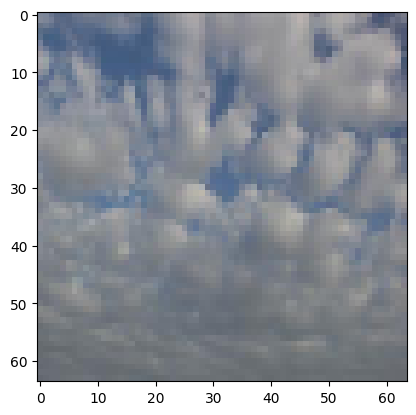

In [23]:
test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
    ]
)

dataset_test = ImageFolder(
    "datasets/clouds/clouds_test",
    transform=test_transforms,
)


dataloader_test = DataLoader(dataset_test, shuffle=True, batch_size=1)

image, label = next(iter(dataloader_test))

# Reshape the image tensor
image = image.squeeze().permute(1, 2, 0)

# Display the image
plt.imshow(image)
plt.show()

In [43]:
# Define metrics
metric_precision = Precision(task="multiclass", num_classes=7, average="micro")
metric_recall = Recall(task="multiclass", num_classes=7, average="micro")

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.7325102686882019
Recall: 0.7325102686882019


In [44]:
# Define metrics
metric_precision = Precision(task="multiclass", num_classes=7, average="macro")
metric_recall = Recall(task="multiclass", num_classes=7, average="macro")

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.7184121608734131
Recall: 0.7956651449203491


### Analyzing metrics per class

While aggregated metrics are useful indicators of the model's performance, it is often informative to look at the metrics per class. This could reveal classes for which the model underperforms.

In this exercise, you will run the evaluation loop again to get our cloud classifier's precision, but this time per-class. Then, you will map these score to the class names to interpret them.

Instructions:

- Define a precision metric appropriate for per-class results.
- Calculate the precision per class by finishing the dict comprehension, iterating over the `.items()` of the `.class_to_idx` attribute of `dataset_test`.

In [45]:
# Define precision metric
metric_precision = Precision(task="multiclass", num_classes=7, average=None)

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
precision = metric_precision.compute()

# Get precision per class
precision_per_class = {k: precision[v].item() for k, v in dataset_test.class_to_idx.items()}
print(precision_per_class)


{'cirriform clouds': 0.7142857313156128, 'clear sky': 0.9411764740943909, 'cumulonimbus clouds': 0.550000011920929, 'cumulus clouds': 0.71875, 'high cumuliform clouds': 0.7247706651687622, 'stratiform clouds': 0.7916666865348816, 'stratocumulus clouds': 0.5882353186607361}
